In [1]:
# libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

## Visualization
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objs as go

### to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

# Clustering lats and longs
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

# sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# handle warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Functions
### set display options
def maxDisplay(df):
    pd.options.display.max_rows = df.shape[0]
    pd.options.display.max_columns = df.shape[1]

### Return column summary
def colSummary(df):
    data = {'Column Type'  :df.dtypes.values,
            'Total Missing':df.isna().sum().values,
            'Total Unique' :df.nunique().values
           }

    colOverview = pd.DataFrame(data, index = df.columns)
    return(colOverview)

### Check for multi collinearity
def correlationMatrix(df):
    data = [
    go.Heatmap(
        z=df.corr().values,
        x=df.columns.values,
        y=df.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0 )
    ]

    layout = go.Layout(
        title='Pearson Correlation of Integer-type features',
        xaxis = dict(ticks=''),
        yaxis = dict(ticks='' ),
        width = 900, height = 700)

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='labelled-heatmap')
    
# removing $ and , from the price
def removesymbols(y):    
    y = y.str.strip('$')
    y = y.str.replace(',',"")
    y = [float(i) for i in y]
    
    return y

### Linear Model
def multi_linearRegression(x,y, x_test):  
    model = sm.OLS(y, x).fit()
    y_pred = model.predict(x) # make the predictions by the model
    y_test_pred = model.predict(x_test[x.columns])
    
    # Print out the statistics
    print(model.summary())

    # residual squared error
    print("\nTraining Performance:")
    predictionPerformance(y_pred, y)
    
    return y_pred, y_test_pred

def predictionPerformance(y_pred, y_act):
    print("\nMean Absolute Error: "    ,metrics.mean_absolute_error(y_act,y_pred))
    print("Mean Squared Error: "     ,metrics.mean_squared_error(y_act,y_pred))
    print("Root Mean Squared Error: ",np.sqrt(metrics.mean_squared_error(y_act,y_pred)))
    
# Best leaf with minimum MAE
def getMAE(model_function, random_state, leaves, train_X, train_y, test_X, test_y):
    mdl = model_function(max_leaf_nodes = leaves, random_state = random_state)
    mdl.fit(train_X, train_y)
    return metrics.mean_absolute_error(mdl.predict(test_X), test_y)

# Model building
def model(model_function, train_X, train_y, test_X, test_y, random_state, calc_leaf_nodes = False):
    # Initialize Model
    if calc_leaf_nodes:
        leaf_candidates = {leaf_candidate*10: getMAE(model_function, random_state, leaf_candidate*10, train_X, train_y, test_X, test_y) for leaf_candidate in range(10,1000,1)}
        best_leaf = min(leaf_candidates, key = leaf_candidates.get)
        mdl = model_function(max_leaf_nodes = best_leaf, random_state = random_state)
    else:    
        mdl = model_function(random_state = random_state)
    
    # Fit
    mdl.fit(train_X, train_y)
    
    # Predict
    mdl_pred = mdl.predict(test_X)
    
    # Model performance
    mdl_mae  = metrics.mean_absolute_error(mdl_pred, test_y)
    
    # Print
    print("Validation MAE: {:,.0f}".format(mdl_mae))
    
    return mdl_pred, mdl_mae

In [3]:
listings = pd.read_csv('../01. Data/listings.csv', low_memory = False)
listings.shape

# Set display options
maxDisplay(listings)

In [4]:
# Let's get a column wise summary
colSummary(listings)

Column Type  Total Missing  \
id                                                 int64              0   
listing_url                                       object              0   
scrape_id                                          int64              0   
last_scraped                                      object              0   
name                                              object             35   
summary                                           object            629   
space                                             object           5422   
description                                       object            219   
experiences_offered                               object              0   
neighborhood_overview                             object           6584   
notes                                             object          11523   
transit                                           object           6302   
access                                            object           8468   
interaction                                       object           7988   
house_rules                                       object           7883   
thumbnail_url                                    float64          20677   
medium_url                                       float64          20677   
picture_url                                       object              0   
xl_picture_url                                   float64          20677   
host_id                                            int64              0   
host_url                                          object              0   
host_name                                         object             12   
host_since                                        object             12   
host_location                                     object             49   
host_about                                        object           8600   
host_response_time                                object           8541   
host_response_rate                                object           8541   
host_acceptance_rate                             float64          20677   
host_is_superhost                                 object             12   
host_thumbnail_url                                object             12   
host_picture_url                                  object             12   
host_neighbourhood                                object           5937   
host_listings_count                              float64             12   
host_total_listings_count                        float64             12   
host_verifications                                object              0   
host_has_profile_pic                              object             12   
host_identity_verified                            object             12   
street                                            object              0   
neighbourhood                                     object            831   
neighbourhood_cleansed                            object              0   
neighbourhood_group_cleansed                     float64          20677   
city                                              object              4   
state                                             object            219   
zipcode                                           object            886   
market                                            object             40   
smart_location                                    object              0   
country_code                                      object              0   
country                                           object              0   
latitude                                         float64              0   
longitude                                        float64              0   
is_location_exact                                 object              0   
property_type                                     object              0   
room_type                                         object              

Business travel ready has only one unique value, hence not useful

In [5]:
# The following columns are useless as they have a lot of missing values. 
## Omitting columns with more than 80% missing values
## We will be losing out on square feet
noUseCols = listings.columns[listings.isna().sum()/listings.shape[0] > 0.8]
df = listings.drop(noUseCols, axis = 1)
df.shape

(20677, 97)

In [6]:
df.head()

id                         listing_url       scrape_id last_scraped  \
0   2818   https://www.airbnb.com/rooms/2818  20190808195507   2019-08-09   
1  20168  https://www.airbnb.com/rooms/20168  20190808195507   2019-08-09   
2  25428  https://www.airbnb.com/rooms/25428  20190808195507   2019-08-09   
3  27886  https://www.airbnb.com/rooms/27886  20190808195507   2019-08-09   
4  28871  https://www.airbnb.com/rooms/28871  20190808195507   2019-08-09   

                                                name  \
0           Quiet Garden View Room & Super Fast WiFi   
1       Studio with private bathroom in the centre 1   
2    Lovely apt in City Centre (w.lift) near Jordaan   
3  Romantic, stylish B&B houseboat in canal district   
4                            Comfortable double room   

                                             summary  \
0           Quiet Garden View Room & Super Fast WiFi   
1  Cozy studio on your own private floor, 100% in...   
2                                                NaN   
3  Stylish and romantic houseboat on fantastic hi...   
4                                                NaN   

                                               space  \
0  I'm renting a bedroom (room overlooking the ga...   
1  For those who like all facets of city life. In...   
2  This nicely furnished, newly renovated apt  is...   
3  For a romantic couple: A beautifully restored ...   
4  In a monumental house right in the center of A...   

                                         description experiences_offered  \
0  Quiet Garden View Room & Super Fast WiFi I'm r...                none   
1  Cozy studio on your own private floor, 100% in...                none   
2  This nicely furnished, newly renovated apt  is...                none   
3  Stylish and romantic houseboat on fantastic hi...                none   
4  In a monumental house right in the center of A...                none   

                               neighborhood_overview  \
0  Indische Buurt ("Indies Neighborhood") is a ne...   
1  Located just in between famous central canals....   
2                                                NaN   
3         Central, quiet, safe, clean and beautiful.   
4                                                NaN   

                                               notes  \
0  From week 38 to week 47 maintenance work to th...   
1  Check-in time from 2pm till 10pm (But it doesn...   
2                                                NaN   
3  we have a canadian canoe for you as well, free...   
4  Washing and drying are for a flat fee of €15 p...   

                                             transit  \
0  The neighbourhood is well served by 24 hours p...   
1  No need to use any transport! All is within a ...   
2  The number 17 and #13 tram stop right outside ...   
3  cental station aprox. 10 minutes on foot, buss...   
4                                                NaN   

                                              access  \
0                                                NaN   
1                                                NaN   
2  The apartment is about 75 meters or 800 square...   
3                 Your own apartment, nothing shared   
4                                                NaN   

                                         interaction  \
0                                                NaN   
1  No curfew, free entrance 27/7 with your own ke...   
2  However, our good friends who live close by ta...   
3  As much as they want, and is possible. I speak...   
4                                                NaN   

                                         house_rules  \
0  Please: - Leave your shoes in the entrance  - ...   
1  This studio/room takes entire floor and has it...   
2  The building is a quiet building, so please do...   
3  All the facilities  are included ( cleaning , ...   
4                                                NaN   

                                         picture_url 

In [7]:
df.bed_type.value_counts()

Real Bed         20498
Pull-out Sofa      119
Futon               40
Airbed              14
Couch                6
Name: bed_type, dtype: int64

## Data Exploration

In [8]:
X = df[['id','latitude','longitude','cleaning_fee','host_is_superhost','security_deposit','accommodates','room_type',
        'bathrooms','bedrooms','availability_30', 'availability_60','availability_90','availability_365',
       'extra_people','number_of_reviews','number_of_reviews_ltm','review_scores_rating','review_scores_accuracy',
       'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
       'review_scores_value','instant_bookable','reviews_per_month','bed_type']].copy()

y = df['price'].copy()

colSummary(X)

Column Type  Total Missing  Total Unique
id                                int64              0         20677
latitude                        float64              0          6189
longitude                       float64              0         10075
cleaning_fee                     object           3721           111
host_is_superhost                object             12             2
security_deposit                 object           6202           152
accommodates                      int64              0            17
room_type                        object              0             3
bathrooms                       float64              6            14
bedrooms                        float64              8            13
availability_30                   int64              0            31
availability_60                   int64              0            61
availability_90                   int64              0            91
availability_365                  int64              0           366
extra_people                     object              0           106
number_of_reviews                 int64              0           393
number_of_reviews_ltm             int64              0           127
review_scores_rating            float64           2816            46
review_scores_accuracy          float64           2827             8
review_scores_cleanliness       float64           2825             9
review_scores_checkin           float64           2837             8
review_scores_communication     float64           2830             8
review_scores_location          float64           2835             8
review_scores_value             float64           2835             9
instant_bookable                 object              0             2
reviews_per_month               float64           2593           743
bed_type                         object              0             5

Can we address the missing values by clustering based on Geo Location?

In [9]:
## Let's first cluster the latitudes and longitudes using dbscan
### Note : Kmeans minimizes the variance and not geodetic distance. 
### There is substantial distortion at latitudes far from the equator, like those of this data set. 
### The algorithm would still “work” but its results are poor and there isn’t much that can be done to improve them

# convert lat's and long's into a 2D array
coords = df[['latitude','longitude']].values

# Use DBSCAN to cluster
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian ### clustering zips within a 0.5 km radius

db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

print('Number of clusters: {}'.format(num_clusters))
print(np.unique(db.labels_, return_counts = True))

Number of clusters: 9
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]), array([   20, 19820,   424,    13,   359,    21,     9,     4,     7]))


As we can see, clustering locations with a 0.5 km radius, doesn't matter as 96% of the data is present in a single cluster. Let's check if we can implement kmeans based on other columns without lat and long.
Let's create dummy variables and visualize using PCA

In [13]:
## is super host? Note: we are converting 12 missing nas to false
X['host_is_superhost'] = pd.get_dummies(df['host_is_superhost'], drop_first = True, prefix = 'host_is_superhost').host_is_superhost_t
X['instant_bookable'] = pd.get_dummies(df['instant_bookable'], drop_first = True, prefix = 'instant_bookable').instant_bookable_t

# ## Create a dummy variables for entire home/apt vs rest
X['entire_home_apt'] = 0
X.loc[X['room_type'] == 'Entire home/apt','entire_home_apt'] = 1

## There are 6 missing values in bathrooms and 8 missing values in bedrooms
## Let's impute the missing values in bathrooms and bedrooms with model
X.loc[X['bathrooms'].isna(), 'bathrooms'] = stats.mode(X.bathrooms.values).mode[0]
X.loc[X['bedrooms'].isna(), 'bedrooms']   = stats.mode(X.bedrooms.values).mode[0]
# impute with median
X['review_scores_rating'] = X.review_scores_rating.fillna(X.review_scores_rating.median())
X['review_scores_accuracy'] = X.review_scores_accuracy.fillna(X.review_scores_accuracy.median())
X['review_scores_cleanliness'] = X.review_scores_cleanliness.fillna(X.review_scores_cleanliness.median())
X['review_scores_checkin'] = X.review_scores_checkin.fillna(X.review_scores_checkin.median())
X['review_scores_communication'] = X.review_scores_communication.fillna(X.review_scores_communication.median())
X['review_scores_location'] = X.review_scores_location.fillna(X.review_scores_location.median())
X['review_scores_value'] = X.review_scores_value.fillna(X.review_scores_value.median())
X['reviews_per_month'] = X.reviews_per_month.fillna(X.reviews_per_month.median())

## Get features to be used for PCA
pca_features = X.drop(['id','latitude','longitude','cleaning_fee','extra_people',
                       'security_deposit','room_type','bed_type'], axis = 1).columns

## Let's plot the dataset as PCA's to understand which clustering technique to be used
X_train = X[pca_features].to_numpy()

# scaling the freatures before PCA
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

pca = PCA()
components = pca.fit_transform(X_train_scaled)

# create labels for the plot
labels = {str(i): f"PC {i+1} ({var:.1f}%)" for i, var in enumerate(pca.explained_variance_ratio_ * 100)}
labels

# use plotly for interactive plots
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4)
)
fig.update_traces(diagonal_visible=False)
fig.show()

As we can see, clustering would not be an ideal choice, because there are no visible clusters. Let's try out multiple linear regression to predict the missing values. First, let's split the data into training and validation and test (missing values)

In [14]:
colSummary(X[pca_features])

Column Type  Total Missing  Total Unique
host_is_superhost                 uint8              0             2
accommodates                      int64              0            17
bathrooms                       float64              0            14
bedrooms                        float64              0            13
availability_30                   int64              0            31
availability_60                   int64              0            61
availability_90                   int64              0            91
availability_365                  int64              0           366
number_of_reviews                 int64              0           393
number_of_reviews_ltm             int64              0           127
review_scores_rating            float64              0            46
review_scores_accuracy          float64              0             8
review_scores_cleanliness       float64              0             9
review_scores_checkin           float64              0             8
review_scores_communication     float64              0             8
review_scores_location          float64              0             8
review_scores_value             float64              0             9
instant_bookable                  uint8              0             2
reviews_per_month               float64              0           743
entire_home_apt                   int64              0             2

In [15]:
# Test set - missing values
x_test = X[X.isna().any(axis = 1)]

# data frame without na in rows
x = X.dropna()
y1 = x['cleaning_fee']
y2 = x['security_deposit']

# remove $ and ,
# y  = removesymbols(y)
y1 = removesymbols(y1)
y2 = removesymbols(y2)
# x['extra_people'] = removesymbols(x['extra_people'])

#### Let's impute cleaning fee
# create train and validation split
x_train, x_val, y_train, y_val = train_test_split(x[pca_features].astype(float), y1, test_size=0.2, random_state=42)

# Correlation matrix for train
correlationMatrix(x_train)

From the correlation matrix, we can see
    1. Bedroom and accomodates are highly correlated
    2. availability30 is stronly correlated to availability 60 and availability 90
    3. Number of reviews is strongly correlated to number of reviews ltm
    
Let's remove accomodates (because it has high standard deviation when compared to bedrooms) and also remove availability 60 and availability 90, number of reviews ltm

instant_bookable, host_is_superhost, review_scores_accuracy, review_scores_communication are removed based on p-values from prior iterations

In [16]:
dropCorrelatedCols = ['accommodates','availability_60','availability_90','number_of_reviews_ltm','instant_bookable'
                        ,'host_is_superhost', 'review_scores_accuracy', 'review_scores_communication']
x_train = x_train.drop(dropCorrelatedCols, axis = 1).copy()

# Assess the performance of the linear model on the validation data
y_train_pred, y_val_pred = multi_linearRegression(x_train,y_train, x_val)

# validation error
print('\nValidation Performance:')
predictionPerformance(y_val_pred, y_val)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.777
Method:                 Least Squares   F-statistic:                              3263.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:40:53   Log-Likelihood:                         -51331.
No. Observations:               11252   AIC:                                  1.027e+05
Df Residuals:                   11240   BIC:                                  1.028e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [17]:
# RMSE value is very less. Let's use Linear regression model to predict the missing cleaning fee
# Use the linear model and predict on the test data
y1_train_pred, y1_test_pred = multi_linearRegression(x[pca_features].drop(dropCorrelatedCols, axis = 1).astype(float), y1, x_test)

# Replace the missing values in the original data
x_test['cleaning_fee_pred'] = y1_test_pred.copy()
# x_test['cleaning_fee_imputed'] = x_test['cleaning_fee']
# x_test.loc[x_test['cleaning_fee'].isna(),'cleaning_fee_imputed'] = x_test['cleaning_fee_pred'].copy()

X.loc[X['cleaning_fee'].isna(),'cleaning_fee'] = x_test['cleaning_fee_pred'].copy()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              4153.
Date:                Tue, 01 Dec 2020   Prob (F-statistic):                        0.00
Time:                        20:41:01   Log-Likelihood:                         -64027.
No. Observations:               14066   AIC:                                  1.281e+05
Df Residuals:                   14054   BIC:                                  1.282e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

<ipython-input-17-8fdbfcb66767>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Let's drop security deposit from the predictor list

In [22]:
df = X.drop(['security_deposit','room_type','bed_type','id','latitude','longitude'], axis = 1)
df['extra_people']  = removesymbols(df['extra_people'])
df['cleaning_fee']  = removesymbols(df['cleaning_fee'])
df['Price'] = removesymbols(y)
df.head()

cleaning_fee  host_is_superhost  accommodates  bathrooms  bedrooms  \
0          60.0                  1             2        1.5       1.0   
1           NaN                  0             2        1.0       1.0   
2          40.0                  0             3        1.0       1.0   
3           0.0                  1             2        1.0       1.0   
4           NaN                  1             2        1.0       1.0   

   availability_30  availability_60  availability_90  availability_365  \
0                8               18               43                89   
1                0                8               34               124   
2                4                6               16                75   
3                6               13               26                66   
4                2                5               12               138   

   extra_people  number_of_reviews  number_of_reviews_ltm  \
0          20.0                267                     30   
1           0.0                283                     67   
2          10.0                  3                      2   
3           0.0                195                     41   
4           0.0                283                     99   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  98.0                    10.0                       10.0   
1                  88.0                     9.0                       10.0   
2                 100.0                    10.0                       10.0   
3                  99.0                    10.0                       10.0   
4                  97.0                    10.0                       10.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                   10.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   
3                   10.0                         10.0                    10.0   
4                   10.0                         10.0                    10.0   

   review_scores_value  instant_bookable  reviews_per_month  entire_home_apt  \
0                 10.0                 1               2.12                0   
1                  9.0                 0               2.46                0   
2                 10.0                 0               0.16                1   
3                 10.0                 1               2.11                0   
4                 10.0                 0               2.59                0   

   Price  
0   59.0  
1   80.0  
2  125.0  
3  150.0  
4   75.0

In [23]:
correlationMatrix(df.astype(float))

###  Top 10 neighborhood

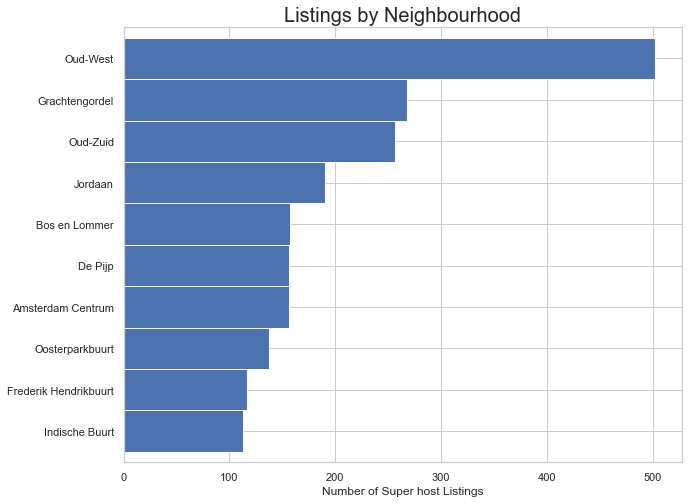

In [65]:
top_neighbourhood_superhost_t = df[df['host_is_superhost'] == 't'].neighbourhood.value_counts().sort_values(ascending = True)
top_neighbourhood_superhost_t[-10:].plot.barh(figsize=(10, 8), color='b', width=1) # select only top 10 and plot
plt.title("Listings by Neighbourhood", fontsize = 20)
plt.xlabel("Number of Super host Listings", fontsize = 12)
plt.show()

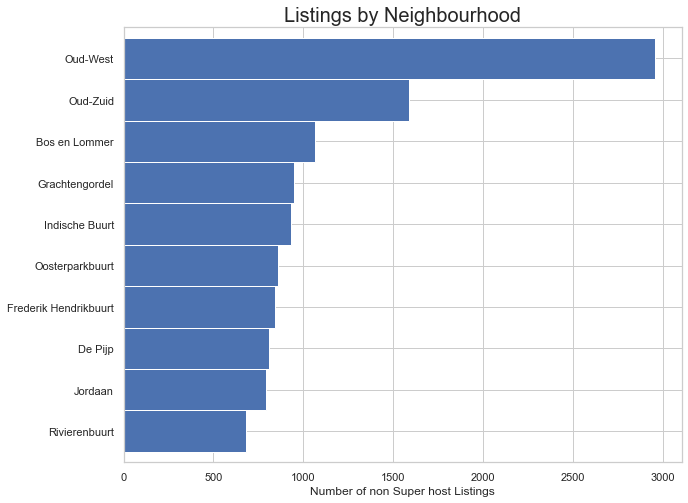

In [64]:
top_neighbourhood_superhost_f = df[df['host_is_superhost'] == 'f'].neighbourhood.value_counts().sort_values(ascending = True)
top_neighbourhood_superhost_f[-10:].plot.barh(figsize=(10, 8), color='b', width=1) # select only top 10 and plot
plt.title("Listings by Neighbourhood", fontsize = 20)
plt.xlabel("Number of non Super host Listings", fontsize = 12)
plt.show()

In [140]:
maps = folium.Map(location=coords[0], zoom_start = 9.5)
FastMarkerCluster(data=coords).add_to(maps)
maps